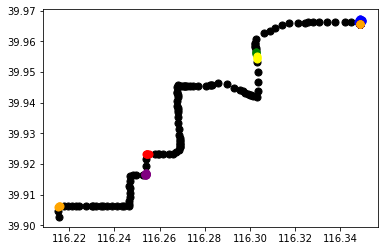

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from geographiclib.geodesic import Geodesic
import datetime
UNCLASSIFIED = False
NOISE = 0
# def load_file(file_name):
#     try:
#         df = pd.read_csv(file_name, encoding='utf-8', sep=',', skiprows=1, header=None)
#         df.fillna('20201102', inplace=True)
#         df1 = np.array(df).tolist()
#         '''按天分段，直接输出每天的数据'''
#         loc_day = [0]
#         for i, info in enumerate(df1):
#             if info[-1] == '20201102':
#                 loc_day.append(i)
#         # print('按天分段的位置点为：', loc_day)
#         split_day_data = [0] * len(loc_day)

#         if len(loc_day) == 1:
#             split_day_data[0] = df1
#         else:
#             for j in range(len(loc_day)):
#                 if j == 0:
#                     split_day_data[j] = df1[0: loc_day[j + 1]]
#                 elif (j > 0) & (j != len(loc_day) - 1):
#                     split_day_data[j] = df1[loc_day[j] + 1: loc_day[j + 1]]
#                 else:
#                     split_day_data[j] = df1[loc_day[j] + 1:]
#         return split_day_data
#     except pd.errors.EmptyDataError:
#         return 0

# def output_data():
#     data_set = []
#     for i in range(1, 25, 1):
#         data = load_file(r'D:\Python\python\6.1\person\p' + str(i) + r'.txt')
#         if data != 0:
#             for value in data:
#                 if value != []:
#                     item = pd.DataFrame(np.array(value), columns=['time', 'lon', 'lat', 'mode'])
#                     data_set.append(item)
#     for j in range(len(data_set)):
#         item = data_set[j]
# #         item.to_csv(r'F:\DataSet\road_network\origin_trajectory\track'+str(j+1)+r'.txt', index=None)

def loadDataSet(Num, interval):
    dataSet = []
    index_save = []
    df0 = pd.read_csv(r'D:\Dataset\Thesis\origin_trajectory\track' + str(Num) + r'.txt', header=0)
    for k in range(0, len(df0), interval):
        index_save.append(k)

    df1 = df0.iloc[index_save]
    df = df1[['lon', 'lat']]
    df.reset_index()
    po_set = df.values.tolist()
    for line in po_set:
        fltline = list(map(float, line))
        dataSet.append(fltline)
    return dataSet, df1		# 输出数据集

def dist(a, b):
    geod = Geodesic.WGS84
    stable_lon = float(a[0])
    stable_lat = float(a[1])
    vary_lon = float(b[0])
    vary_lat = float(b[1])
    line_point = geod.Inverse(stable_lat, stable_lon, vary_lat, vary_lon)
    dis = line_point['s12']
    return dis		# 向量之间的欧氏距离

def eps_neighbor(a, b, eps):
    return dist(a, b) < eps		# 向量之间距离是否满足阈值要求

def region_query(data, pointId, eps):	# 输出：在eps范围内的点的id
    nPoints = data.shape[1]
    seeds = []
    for i in range(nPoints):
        if eps_neighbor(data[:, pointId], data[:, i], eps):
            seeds.append(i)
    return seeds

def expand_cluster(data, clusterResult, pointId, clusterId, eps, minPts):
    # 输入：数据集, 分类结果, 待分类点id, 簇id, 半径大小, 最小点个数
    # 输出：能否成功分类
    # 如果阈值范围内点数小于eps，则clusterResult为簇ID-pointID
    seeds = region_query(data, pointId, eps)
    if len(seeds) < minPts:      # 不满足minPts条件的为噪声点
        clusterResult[pointId] = NOISE
        return False
    else:
        core_point[clusterId] = []
        clusterResult[pointId] = clusterId      # 划分到该簇
        for seedId in seeds:
            clusterResult[seedId] = clusterId
        seeds = seeds[1:]
        while len(seeds) > 0:       # 持续扩张
            currentPoint = seeds[0]
            queryResults = region_query(data, currentPoint, eps)
            if len(queryResults) >= minPts:
                core_point[clusterId].append(currentPoint)
                for i in range(len(queryResults)):
                    resultPoint = queryResults[i]
                    if clusterResult[resultPoint] == UNCLASSIFIED:
                        seeds.append(resultPoint)
                        clusterResult[resultPoint] = clusterId
                    elif clusterResult[resultPoint] == NOISE:
                        clusterResult[resultPoint] = clusterId
            seeds = seeds[1:]
        return True

def dbscan(data, eps, minPts):		# 输入：数据集，e，MinPts；输出：分类簇id
    clusterId = 1
    nPoints = data.shape[1]
    clusterResult = [UNCLASSIFIED] * nPoints
    for pointId in range(nPoints):
        point = data[:, pointId]
        if clusterResult[pointId] == UNCLASSIFIED:
            if expand_cluster(data, clusterResult, pointId, clusterId, eps, minPts):
                clusterId = clusterId + 1
    cluster_point = {}
    for i in range(1, clusterId):
        cluster_point[i] = []
        for j, element in enumerate(clusterResult):
            if element == i:
                cluster_point[i].append(j)
    return clusterResult, clusterId - 1, cluster_point

def plotFeature(data, clusters, clusterNum ):
    nPoints = data.shape[1]
    matClusters = np.mat(clusters).transpose()
    fig = plt.figure()
    scatterColors = ['black', 'blue', 'green', 'yellow', 'red', 'purple', 'orange', 'brown']
    ax = fig.add_subplot(111)
    for i in range(clusterNum + 1):
        colorSytle = scatterColors[i % len(scatterColors)]
        subCluster = data[:, np.nonzero(matClusters[:, 0].A == i)]
        ax.scatter(subCluster[0, :].flatten().A[0], subCluster[1, :].flatten().A[0], c=colorSytle, s=50)
    # ax.text(x=0.7, y=0.6, s=f'field is {eps}')
    # ax.text(x=0.7, y=0.5, s=f'number is {minPts}')

def main(Num, interval):
    dataSet, df_result = loadDataSet(Num, interval)
    dataSet = np.mat(dataSet).transpose()
    global core_point
    core_point = {}			# 筛选核心点index
    clusters, clusterNum, cluster_poi = dbscan(dataSet, 70, 4)		# 12，3效果比较好
    # print('聚类的数目为：', clusterNum)
    # print('核心对象为：',core_point)
    # print('密度直达点为：',cluster_poi)
    for key in core_point.keys():
        n = int(len(core_point[key]) / 6) + 1
        for i in range(n-1):
            cluster_poi[key].remove(core_point[key][6*i])
    del_poi = []
    for key, value in cluster_poi.items():
        for k in value:
            del_poi.append(k)

    df_result.drop(df_result.index[del_poi], axis=0 ,inplace=True)

    df_result.reset_index()
    num = len(df_result)
#     df_result.to_csv(r'F:\DataSet\road_network\trajectory' + str(interval)+ r'\track' + str(Num)+ r'.txt', index=None)

    # print('需要删除点的下标为：',del_poi)
    plotFeature(dataSet, clusters, clusterNum)
    return num


def generate_track():
    if __name__ == '__main__':
        interval_set = [4]
        for interval in interval_set:
            for Num in range(1, 2):
                main(Num, interval)
generate_track()